# Algorytmy genetyczne - problem Komiwojażera

### Import bibliotek

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.spatial import distance_matrix

### Funkcja generująca punkty

In [2]:
def generate_cities(n_cities, area_size):
    return pd.DataFrame({"X": np.random.randint(area_size, size=n_cities), "Y": np.random.randint(area_size, size=n_cities)})

(0.0, 210.0)

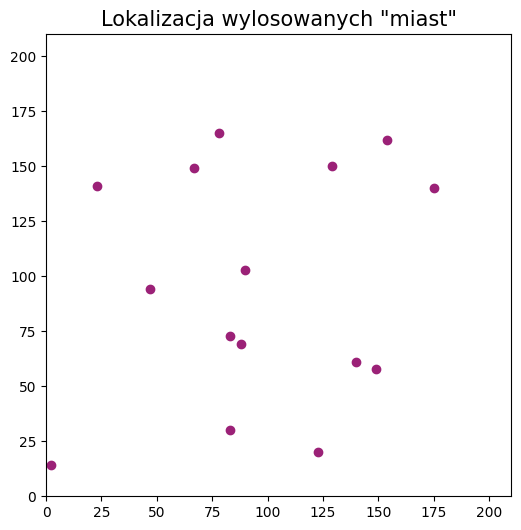

In [3]:
cities = generate_cities(15, 200)
plt.figure(figsize = (6,6))
plt.scatter(cities.X, cities.Y, color="#9B2177")
plt.title('Lokalizacja wylosowanych "miast"', fontsize=15)
plt.xlim(0,210)
plt.ylim(0,210)

### Przedstawienie koordynatów

In [4]:
display(cities.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
X,175,123,83,2,78,90,47,88,154,129,149,140,83,67,23
Y,140,20,73,14,165,103,94,69,162,150,58,61,30,149,141


### Macierz dystansu

In [5]:
def distances(cities):
    return pd.DataFrame(distance_matrix(cities.values, cities.values), index=cities.index, columns=cities.index)

In [58]:
dist = distances(cities)

### Wybór populacji początkowej

In [7]:
def genesis(cities, n_population):
    n_cities = len(cities)
    population_set = []
    for i in range(n_population):
        city = np.random.permutation(cities)
        population_set.append(city)
    population_df = pd.DataFrame(population_set, columns=['City_' + str(i) for i in range(1, n_cities + 1)])
    return population_df

In [8]:
population = genesis(cities.index, 15)
display(population)

,City_1,City_2,City_3,City_4,City_5,City_6,City_7,City_8,City_9,City_10,City_11,City_12,City_13,City_14,City_15
0,4,0,9,8,11,7,14,5,10,3,2,1,12,6,13
1,5,0,13,4,3,8,6,11,10,7,2,1,12,9,14
2,6,2,1,12,13,7,3,11,5,8,4,0,9,14,10
3,8,1,2,5,9,14,7,3,0,13,12,4,11,10,6
4,7,12,9,6,3,2,11,1,13,14,4,0,8,5,10
5,1,2,4,5,0,3,9,14,11,13,10,7,6,8,12
6,13,5,9,4,6,8,14,7,1,0,2,3,10,12,11
7,11,2,4,6,3,14,9,13,7,5,8,12,10,0,1
8,3,12,14,2,10,8,0,5,9,1,13,4,6,7,11
9,6,2,14,4,7,5,10,1,11,0,9,3,12,8,13


### Ocena populacjii

In [9]:
def compute_fitness(population_df, distance_matrix):
    fitness_values = []
    for idx, solution in population_df.iterrows():
        solution_distance = 0
        for i in range(len(solution) - 1):
            city1 = solution.iloc[i]
            city2 = solution.iloc[i + 1]
            solution_distance += distance_matrix.loc[city1, city2]
        first_city = solution.iloc[0]
        last_city = solution.iloc[len(solution) - 1]
        solution_distance += distance_matrix.loc[last_city, first_city]
        fitness_values.append(solution_distance)
    return fitness_values

In [10]:
fitness = compute_fitness(population, dist)
display(fitness)

[1090.436140516851,
 1324.5806631071496,
 1341.034629410889,
 1552.1589235070257,
 1160.9393964687956,
 1627.3370362775886,
 1408.966758995272,
 1303.341926107475,
 1269.4992944152227,
 1186.0768874807077,
 1436.8660616866873,
 1266.8713745906466,
 1227.6144934205809,
 1450.0757287441434,
 1127.0691803869674]

### Selekcja - metoda ruletki

In [11]:
def roulette_selection(fitness_list, population_df):
    inverse_fitness_list = 1 / np.array(fitness_list)
    total_fit = inverse_fitness_list.sum()
    prob_list = inverse_fitness_list/total_fit
    parents_indices = np.random.choice(list(range(len(population_df))), size=2, p=prob_list, replace=True)
    return population_df.loc[parents_indices[0],:], population_df.loc[parents_indices[1],:]

In [57]:
selected_1, selected_2 = roulette_selection(fitness, population)

### Krzyżowanie

In [42]:
def fix_duplicates(child, n_cities):
    city_counts = child.value_counts()
    duplicates = city_counts[city_counts > 1]
    missing_cities = list(set(range(n_cities)) - set(child))
    for duplicate in duplicates.index:
        duplicate_indices = [i for i, x in enumerate(child) if x == duplicate]
        for idx in duplicate_indices:
            if missing_cities:
                child.iloc[idx] = missing_cities.pop()
    return child

In [45]:
def crossover(parent_a, parent_b, crossover_prob):
    n_cities = len(parent_a)
    if np.random.rand() < crossover_prob:
        start_point = np.random.randint(0, n_cities - 1)
        end_point = np.random.randint(start_point + 1, n_cities)
        child_a = pd.concat([parent_a[:start_point],parent_b[start_point:end_point],parent_a[end_point:]])
        child_b = pd.concat([parent_b[:start_point],parent_a[start_point:end_point],parent_b[end_point:]])
        child_a = fix_duplicates(child_a, n_cities)
        child_b = fix_duplicates(child_b, n_cities)
    else:
        child_a, child_b = parent_a, parent_b
    return child_a, child_b

In [51]:
child_a, child_b = crossover(selected_1, selected_2, 0.8)
print(child_a)

City_1      2
City_2      1
City_3     14
City_4      8
City_5     12
City_6      9
City_7     10
City_8      0
City_9      3
City_10    13
City_11    10
City_12     7
City_13     6
City_14     4
City_15     5
dtype: int64


### Mutacja

In [55]:
def mutate(individ, mutation_prob = 0.8):
    if np.random.rand() < mutation_prob:
        n_cities = len(individ)
        idx1, idx2 = np.random.choice(n_cities, 2, replace=False)
        individ.iloc[idx1], individ.iloc[idx2] = individ.iloc[idx2], individ.iloc[idx1]
    return individ

In [56]:
child_a = mutate(child_a)
child_b = mutate(child_b)

### Generowanie nowej populacji

In [17]:
def create_new_generation(current_population_df, fitness_values, crossover_prob, mutation_prob, selection_type='roulette'):
    new_generation = []
    if selection_type == 'roulette':
        selected_population_df = roulette_selection(fitness_values, current_population_df)
    elif selection_type == 'ranking':
        selected_population_df = ranking_selection(fitness_values, current_population_df)
    
    for i in range(0, len(selected_population_df), 2):
        parent_1 = selected_population_df.iloc[i].values[:-1]
        parent_2 = selected_population_df.iloc[i + 1].values[:-1]
        child_1, child_2 = order_crossover(parent_1, parent_2, crossover_prob)
        child_1 = mutate(child_1, mutation_prob)
        child_2 = mutate(child_2, mutation_prob)
        new_generation.append(child_1)
        new_generation.append(child_2)
    
    new_generation_df = pd.DataFrame(new_generation, columns=['City_' + str(i) for i in range(1, len(current_population_df.columns))])
    return new_generation_df
    

## Implementacja algorytmu genetycznego

In [18]:
def genetic_algorithm(num_cities, num_individuals, generations, mutation_rate, crossover_rate):
    cities = generate_cities(num_cities, 200)
    distance_mat = distances(cities)
    population = genesis(cities, num_individuals)
    
    best_fitness_over_generations = []
    avg_fitness_over_generations = []
    median_fitness_over_generations = []
    all_fitness_scores = []

    for generation in range(generations):
        fitness_values, population = compute_fitness(population, distance_mat)
        best_fitness_over_generations.append(min(fitness_values))
        avg_fitness_over_generations.append(np.mean(fitness_values))
        median_fitness_over_generations.append(np.median(fitness_values))
        all_fitness_scores.append(fitness_values)
        
        population = create_new_generation(population, distance_mat, crossover_rate, mutation_rate)
    
    best_idx = np.argmin(fitness_values)
    best_individual = population.iloc[best_idx, :-1].values
    best_distance = fitness_values[best_idx]
    
    return best_individual, best_distance, all_fitness_scores, best_fitness_over_generations, avg_fitness_over_generations, median_fitness_over_generations, cities

### Najlepsza trasa w danym pokoleniu
#### Funkcja do wizualizacji

In [19]:
def best_route(population_df, cities_df):
    index = population_df["Fitness"].idxmin()
    route = population_df.iloc[index, :-1].values
    plt.figure(figsize=(6, 6))
    plt.plot(cities_df.loc[route, "X"], cities_df.loc[route, "Y"], color="#efaffa")
    plt.scatter(cities_df["X"], cities_df["Y"], color="#8f00a8")
    plt.xlim(0, 210)
    plt.ylim(0, 210)
    plt.title("Najlepsza droga w obecnej populacji")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True)

### Funkcja wizualizująca poprawę jakości

In [20]:
def plot_evolution(best_fitness, avg_fitness, median_fitness, generations):
    plt.figure(figsize=(10, 6))
    plt.plot(generations, best_fitness, 'bo-', label='Najlepszy wynik')
    plt.plot(generations, avg_fitness, 'go-', label='Średnia')
    plt.plot(generations, median_fitness, 'ro-', label='Mediana')
    plt.fill_between(generations, median_fitness, color='red', alpha=0.1)
    plt.xlabel('Pokolenia')
    plt.ylabel('Wartość funkcji jakości')
    plt.title('Ewolucja jakości w kolejnych pokoleniach')
    plt.legend()
    plt.grid(True)
    plt.show()

In [21]:
best_individual, best_distance, all_fitness_scores, best_fitness_over_generations, avg_fitness_over_generations, median_fitness_over_generations, cities = genetic_algorithm(num_cities=15, num_individuals=50, generations=400, mutation_rate=0.01, crossover_rate=0.9)

best_route(cities, best_individual)
generations = list(range(1, 401))
plot_evolution(best_fitness_over_generations, avg_fitness_over_generations, median_fitness_over_generations, generations)

print(f'Najlepsza znaleziona trasa ma długość: {best_distance}')

ValueError: Must pass 2-d input. shape=(50, 15, 2)